In [4]:
! python -V
! pwd

Python 3.6.8 :: Anaconda, Inc.
/home/martin/ml


In [5]:
import torch
import torchvision.datasets
import torch.utils.data
import torch.nn
import torch.nn.functional as F
import os
import numpy as np
import datetime
import math

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import tensorboardX

In [8]:
base_path = '/home/martin/ml/'
tmp_tf_log_dir = f'{base_path}tmp/tf_log/'

In [9]:
if not os.path.exists(tmp_tf_log_dir):
    os.makedirs(tmp_tf_log_dir)

In [10]:
path_tf_log = f'{tmp_tf_log_dir}{datetime.datetime.now()}'
tensor_board_writer = tensorboardX.SummaryWriter(log_dir=path_tf_log)

In [11]:
BATCH_SIZE = 64

if not os.path.exists(base_path):
    os.makedirs(base_path)

dataset_train = torchvision.datasets.MNIST(
    root=f'{base_path}/minst',
    download=True,
    train=True,
    transform=torchvision.transforms.ToTensor()
)

dataset_test = torchvision.datasets.MNIST(
    root=f'{base_path}/minst',
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

loader_train = torch.utils.data.DataLoader(
    dataset_train,
    BATCH_SIZE,
    shuffle=True
)

loader_test = torch.utils.data.DataLoader(
    dataset_test,
    BATCH_SIZE,
    shuffle=False
)

In [12]:
loader_test.dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /home/martin/ml//minst
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [13]:
def init_dict_rand(dict_size):
    d = np.linspace(-3,3,dict_size)
    a = np.random.normal(0,1,dict_size)
    return a, d

def gaussian_kernel(s, di):
    gamma = 0.4
    return math.exp(-gamma * ((s-di)**2))
    
def kaf(s, a, d):
    a = a.reshape(a.shape[0])
    d = d.reshape(d.shape[0])
    D = list(zip(d,a))
    kaf_ret = 0
    for dd,aa in D:
        kaf_ret = kaf_ret + aa * gaussian_kernel(s, dd)
        
    return kaf_ret

def kaf_np_arr(S, a, d):
    ret = []
    
    for s in S:
        ret.append(kaf(s, a, d))
    
    return np.array(ret)

In [14]:
relu = lambda x : np.maximum(x,np.zeros(x.size))
sigmoid = lambda x : 1 / (1+np.exp(-x))
     
def kernel_ridge_regression(kernel, dict_size):
       
    relu = lambda x : np.maximum(x,np.zeros(x.size))
    sigmoid = lambda x : 1 / (1+np.exp(-x))
     
    d = np.linspace(-3,3,dict_size)
    
    #Kernel ridge regression will work with any activation function
    t = relu(d)
    #t = sigmoid(d)
    
    d = d.reshape(d.shape[0],1)
    t = t.reshape(d.shape[0],1)

    K = np.zeros([d.size,d.size])

    for idx_i, i in enumerate(d):
        for idx_j, j in enumerate(d):
            K[idx_i][idx_j] = kernel(i[0],j[0]) 

    I = np.eye(d.size)
    epsilon = 0.001
    
    inv = np.linalg.inv(K + epsilon * I) 
    a = inv @ t
    
    return a, d

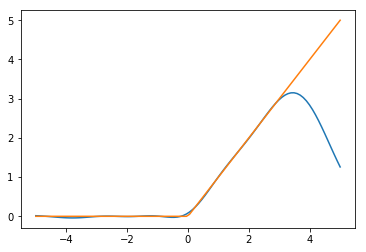

In [15]:
#Test kernel ridge regression

fig = plt.figure()
ax = plt.axes()

a, d = kernel_ridge_regression(gaussian_kernel, 40)

x = np.linspace(-5,5,100)
ax.plot(x, kaf_np_arr(x, a, d));
ax.plot(x, relu(x))

In [16]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # pirms conv_1 (1, 28, 28) , W = 28
        W = 28

        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, padding=0, stride=2)
        O_1 = int((W - self.conv_1.kernel_size[0] + 2*self.conv_1.padding[0]) / self.conv_1.stride[0] + 1)

        #Create initial kernel params ar RELU
        a, d =  kernel_ridge_regression(gaussian_kernel, 25)   
        a = a.reshape(a.shape[0])
        d = d.reshape(d.shape[0])
        
        #a, d = init_dict_rand(25)
        
        self.kaf_conv1_mix_ceof = torch.from_numpy(a).double()
        self.kaf_conv1_mix_ceof.requires_grad=True
        #Make it a nn.Parameter so that it's included in backprop for update
        self.kaf_conv1_mix_ceof = torch.nn.Parameter(self.kaf_conv1_mix_ceof)
        
        self.kaf_conv1_dict = torch.from_numpy(d).double()
        
        self.conv_2 = torch.nn.Conv2d(in_channels=5, out_channels=15, kernel_size=5, padding=0, stride=2)
        O_2 = int((O_1 - self.conv_2.kernel_size[0] + 2*self.conv_2.padding[0]) / self.conv_2.stride[0] + 1)
        
        # Create KAF for conv2 randomly 
        a, d = init_dict_rand(25)
        self.kaf_conv2_mix_ceof = torch.from_numpy(a).double()
        self.kaf_conv2_mix_ceof.requires_grad=True
        self.kaf_conv2_mix_ceof = torch.nn.Parameter(self.kaf_conv2_mix_ceof)
            
        self.kaf_conv2_dict = torch.from_numpy(d).double()

        O_3 = int(O_2 * O_2 * self.conv_2.out_channels)
        self.O_3 = O_3

        self.fc_1 = torch.nn.Linear(in_features=O_3, out_features=int(O_3/2))
        
        # Create KAF for fc1 randomly
        a, d = init_dict_rand(25)        
        self.kaf_fc1_mix_ceof = torch.from_numpy(a).double()
        self.kaf_fc1_mix_ceof.requires_grad=True
        self.kaf_fc1_mix_ceof = torch.nn.Parameter(self.kaf_fc1_mix_ceof)
        
        
        self.kaf_fc1_dict = torch.from_numpy(d).double()
        
        self.fc_2 = torch.nn.Linear(in_features=int(O_3/2), out_features=10) # 10 klases

    
    def gaussian_kernel(self, s, di):
        gamma = 0.4
        return torch.exp(-gamma * ((s-di)**2))

    #Most likely we can vectorize this function. Didn't think too hard about it yet. 
    def kaf(self, s, a, d):  
        kaf_ret = torch.zeros(s.shape, dtype=torch.float64)
        for idx, (di, ai) in enumerate(zip(d,a)):
            kaf_ret = kaf_ret + ai * self.gaussian_kernel(s, di)
        return kaf_ret
    
    
    def forward(self, x, use_kaf = False):
        # x = (BATCH_SIZE, CHANNELS, W, H)
        #x = self.conv_1.forward(x.cuda())
        x = self.conv_1.forward(x)

        
        if (use_kaf == True):
            x = self.kaf(x, self.kaf_conv1_mix_ceof, self.kaf_conv1_dict)
        else:
            x = F.relu(x)
    
        x = self.conv_2.forward(x)
        
        if (use_kaf == True):
            x = self.kaf(x, self.kaf_conv2_mix_ceof, self.kaf_conv2_dict)
        else:
            x = F.relu(x)
        
        # x = (BATCH_SIZE, CHANNELS, W, H)
        x = x.view(-1, self.fc_1.in_features)
        # x = (BATCH_SIZE, CHANNELS * W * H)

        x = self.fc_1(x)
        
        if (use_kaf == True):
            x = self.kaf(x, self.kaf_fc1_mix_ceof, self.kaf_fc1_dict)
        else:
            x = F.relu(x)
        

        x = self.fc_2(x)
        # x = (BATCH_SIZE, 10)

        x = F.softmax(x, dim=1)
        return x

In [17]:
model = Model().double()
#model = model.cuda()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=1e-4)

In [18]:
print(model.kaf_conv2_mix_ceof)
print(model.kaf_conv2_dict)

Parameter containing:
tensor([-2.5910, -0.8502, -0.4248,  0.1098, -1.1635, -0.4434, -1.1000, -0.4989,
        -0.6555,  1.5912,  2.5917, -0.3251, -0.8798, -0.3783, -0.5007, -1.2416,
         1.3202, -1.0288,  1.2093,  0.7636, -1.4922,  1.6800, -0.1088, -1.3532,
         1.0944], dtype=torch.float64, requires_grad=True)
tensor([-3.0000, -2.7500, -2.5000, -2.2500, -2.0000, -1.7500, -1.5000, -1.2500,
        -1.0000, -0.7500, -0.5000, -0.2500,  0.0000,  0.2500,  0.5000,  0.7500,
         1.0000,  1.2500,  1.5000,  1.7500,  2.0000,  2.2500,  2.5000,  2.7500,
         3.0000], dtype=torch.float64)


In [19]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
def add_result_to_tensorboard(x, y, tag, step, title=""):
    x_np = x.to('cpu').data.numpy()
    y_np = y.to('cpu').data.numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1) #row, col, idx
    ax.imshow(x_np)
    
    ax = fig.add_subplot(1, 2, 2)
    y_ticks = np.arange(len(y_np))
    ax.barh(y_ticks, y_np)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(range(10))    # For ticks labels should be 0..9
    ax.set_title(title)
       
    canvas_render = FigureCanvas(fig)
    canvas_render.draw()
    w, h = fig.canvas.get_width_height()
    img = np.fromstring(canvas_render.tostring_rgb(), dtype=np.uint8).reshape(int(h), int(w), 3)
    img = np.swapaxes(img, 2, 0)
    img = np.swapaxes(img, 2, 1)
    tensor_board_writer.add_image(tag=tag, img_tensor=img, global_step=step)
    
    
    #plt.show()
    #exit()

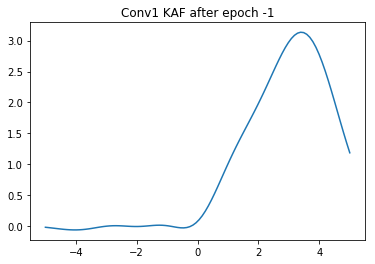

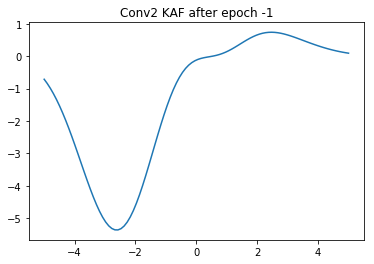

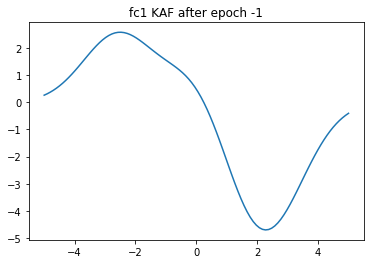

In [20]:
import matplotlib.pyplot as plt

def show_kaf(a, d, title=""):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_title(title)

    x = np.linspace(-5,5,100)
    out = np.zeros(x.shape)
    
    for idx,s in enumerate(x):
        out[idx] = model.kaf(s,a,d)
    
    ax.plot(x, out)
    
    plt.show()
    
epoch = -1
show_kaf(model.kaf_conv1_mix_ceof, model.kaf_conv1_dict, title = f"Conv1 KAF after epoch {epoch}")
show_kaf(model.kaf_conv2_mix_ceof, model.kaf_conv2_dict, title = f"Conv2 KAF after epoch {epoch}")
show_kaf(model.kaf_fc1_mix_ceof, model.kaf_fc1_dict, title = f"fc1 KAF after epoch {epoch}")

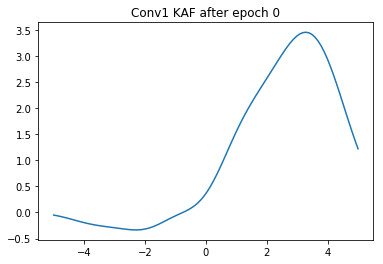

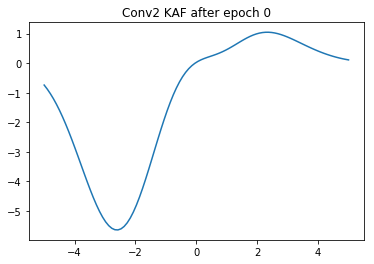

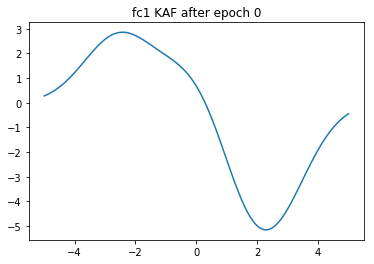

epoch: 1 loss: 18.4298961910732 acc_avg: 0.9130175159235668


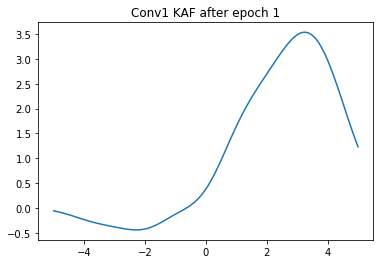

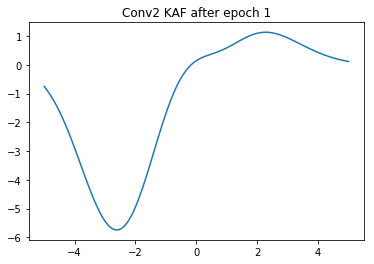

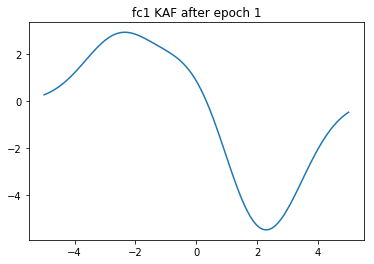

epoch: 2 loss: 11.845319911956075 acc_avg: 0.943968949044586


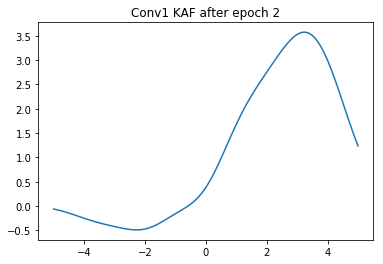

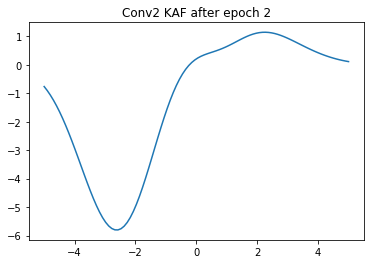

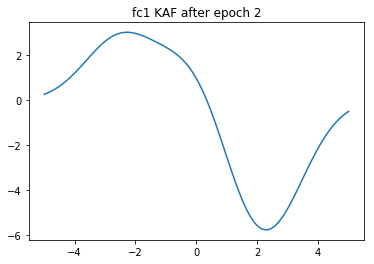

epoch: 3 loss: 9.152677262075859 acc_avg: 0.9574044585987261


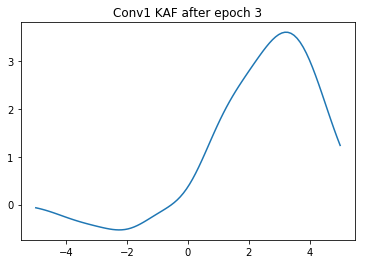

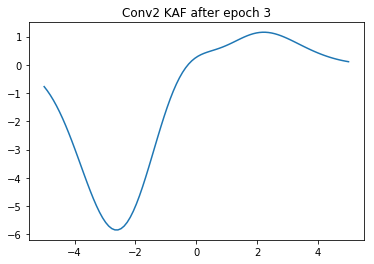

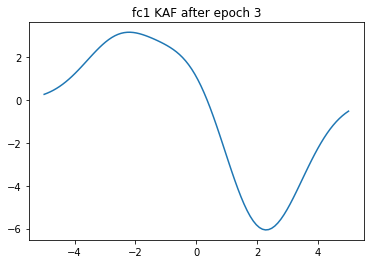

epoch: 4 loss: 7.3298331360601425 acc_avg: 0.9656648089171974


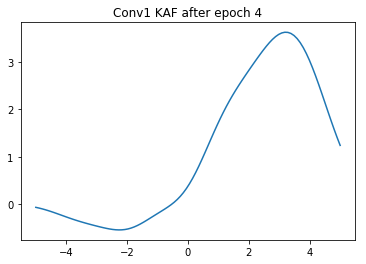

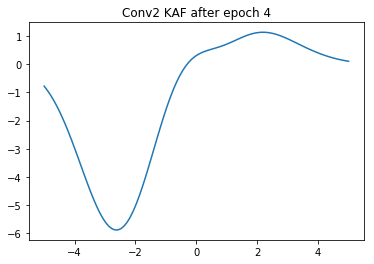

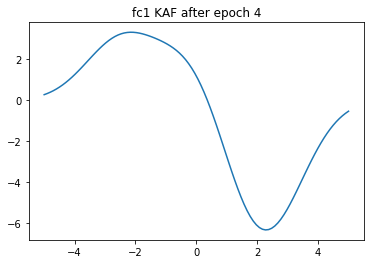

epoch: 5 loss: 6.606855035524955 acc_avg: 0.9677547770700637


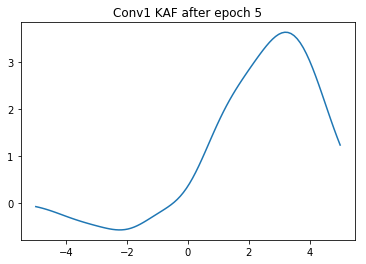

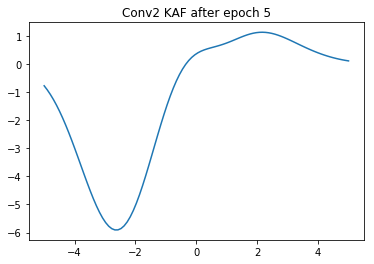

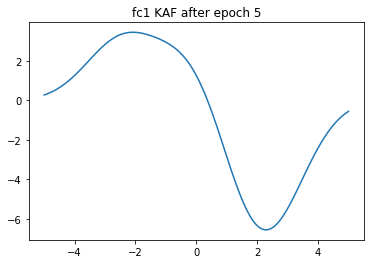

epoch: 6 loss: 6.01039591046823 acc_avg: 0.9691480891719745


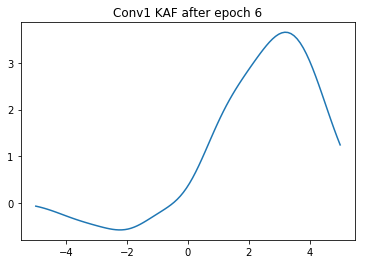

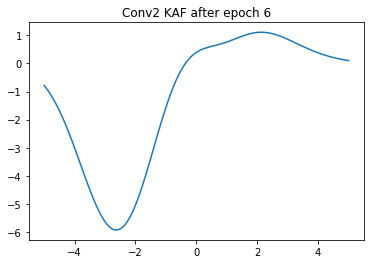

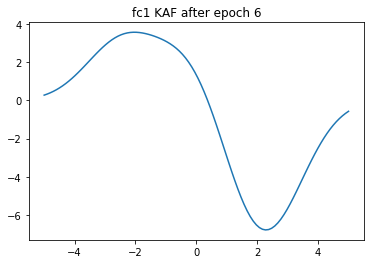

epoch: 7 loss: 5.12732961906752 acc_avg: 0.9741242038216561


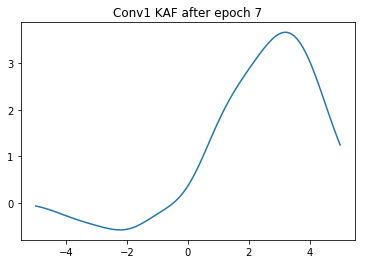

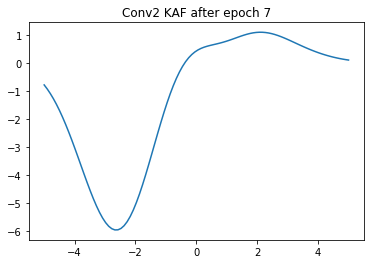

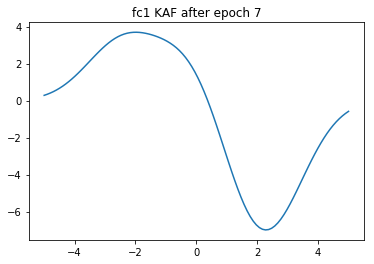

epoch: 8 loss: 4.776234860423134 acc_avg: 0.9754179936305732


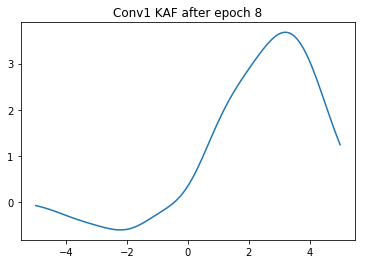

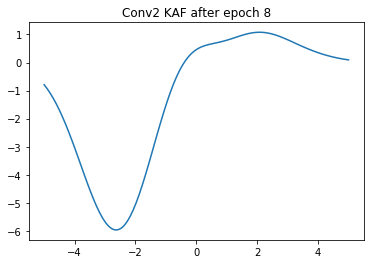

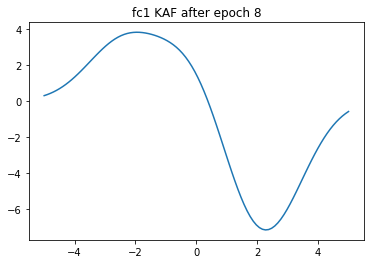

epoch: 9 loss: 4.7088916665041225 acc_avg: 0.9766122611464968


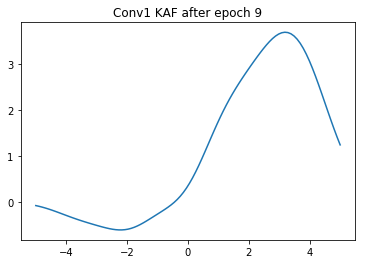

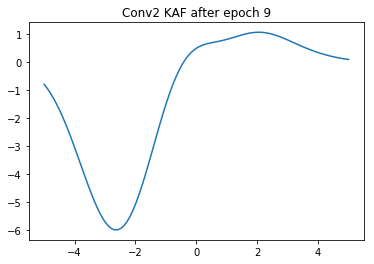

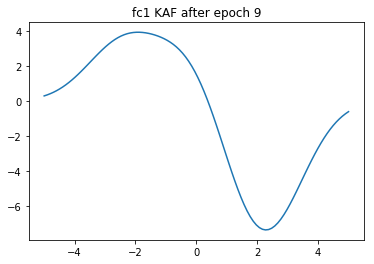

epoch: 10 loss: 4.538909261025138 acc_avg: 0.9774084394904459


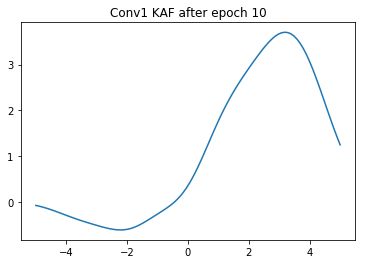

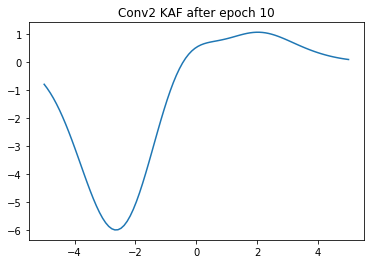

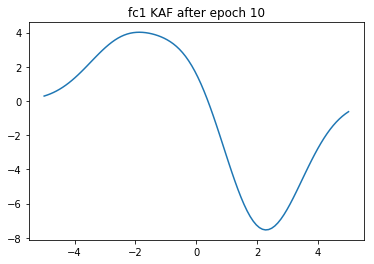

epoch: 11 loss: 4.2695320524300495 acc_avg: 0.9782046178343949


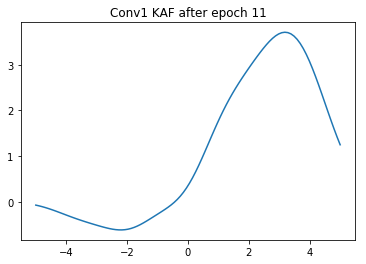

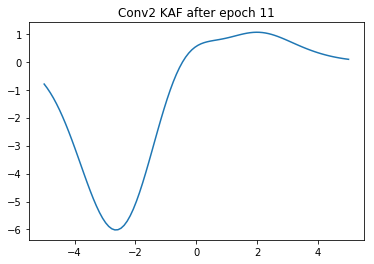

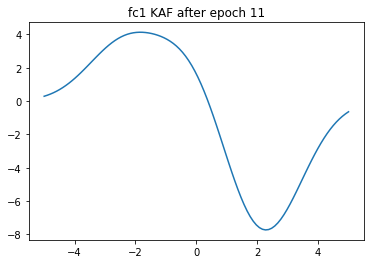

epoch: 12 loss: 4.2139905551741474 acc_avg: 0.9788017515923567


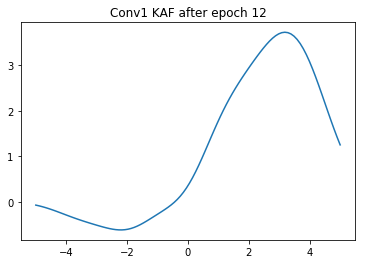

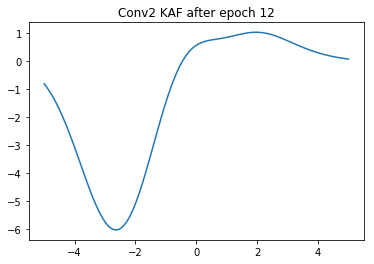

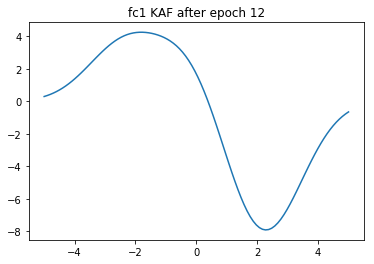

epoch: 13 loss: 4.098052895499041 acc_avg: 0.9793988853503185


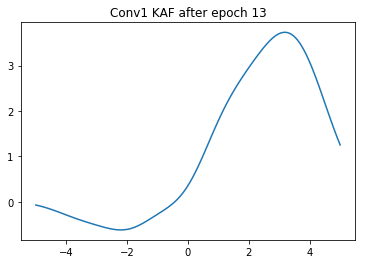

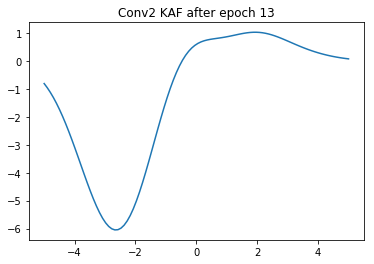

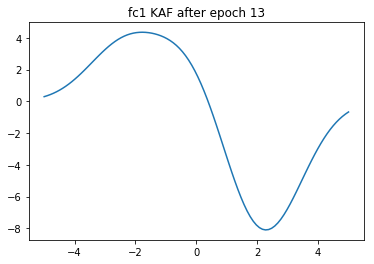

epoch: 14 loss: 4.066345410354779 acc_avg: 0.9796974522292994


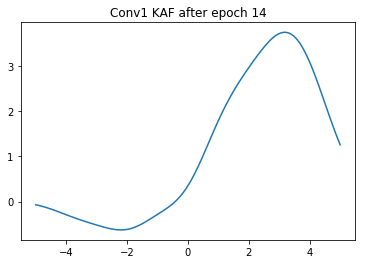

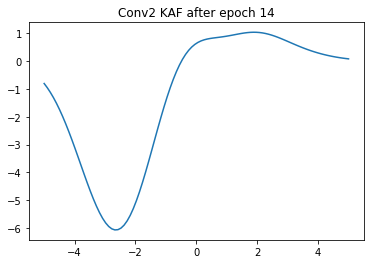

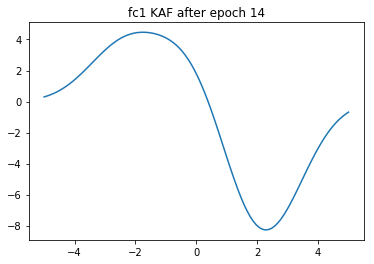

epoch: 15 loss: 3.9983046666839637 acc_avg: 0.9800955414012739


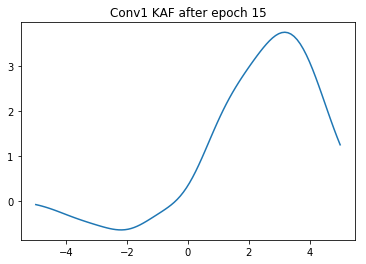

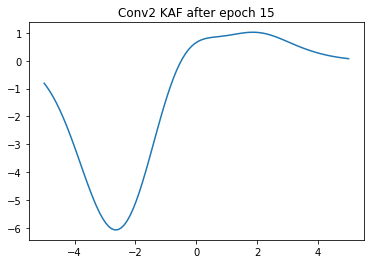

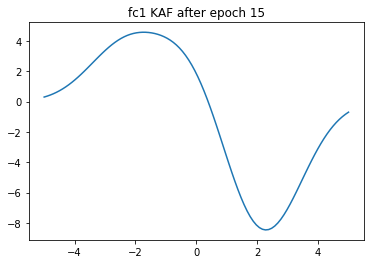

epoch: 16 loss: 4.029828185488835 acc_avg: 0.979796974522293


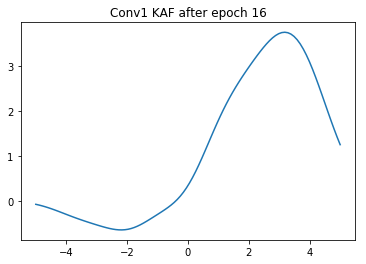

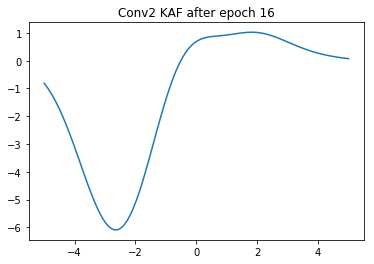

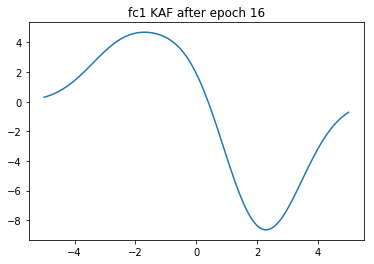

epoch: 17 loss: 4.242653459985164 acc_avg: 0.9791003184713376


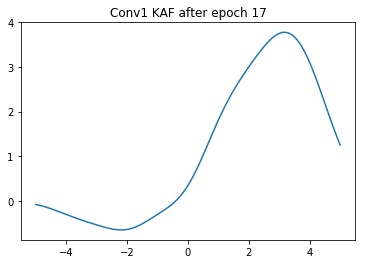

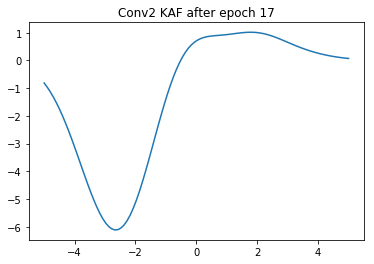

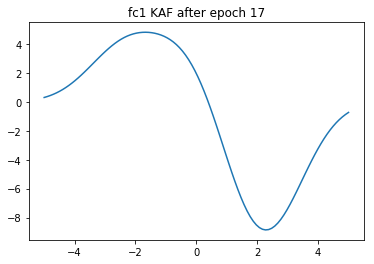

epoch: 18 loss: 4.0351231971651496 acc_avg: 0.9812898089171974


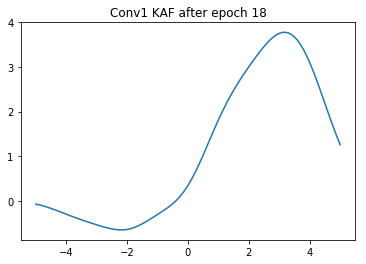

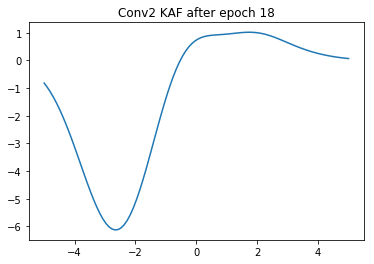

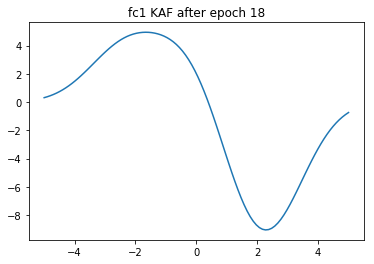

epoch: 19 loss: 4.206843936220621 acc_avg: 0.9795979299363057


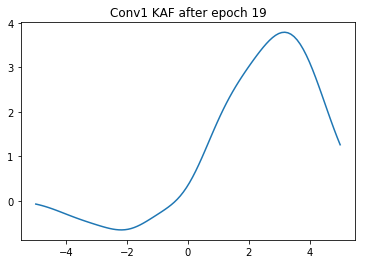

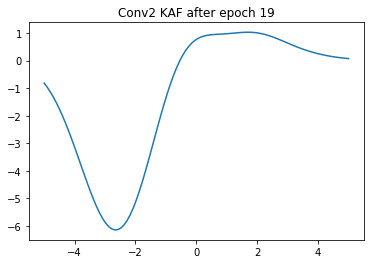

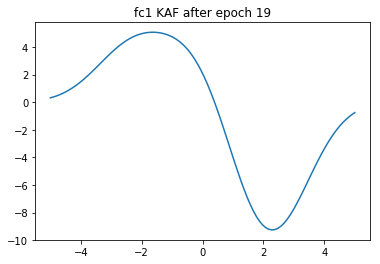

epoch: 20 loss: 4.206484227289876 acc_avg: 0.9798964968152867


In [21]:
for epoch in range(20):
    wrong_pred_co = 0
    for loader in [loader_train, loader_test]:
        losses = list()
        accuracy = []
        loader_steps = 0
        for x, y_idxes in loader:
        

            #x = x.cuda()
            #y_idxes = y_idxes.cuda()
            
            # y_idxes = (BATCH_SIZE) contains class indexes
            y = y_idxes.reshape(y_idxes.size(0), 1)
            #tmp = torch.arange(10).reshape(1, 10).cuda()
            tmp = torch.arange(10).reshape(1, 10)
            
            y = (y == tmp).double() # FloatTensor
            # y = (BATCH_SIZE, 10)

            y_prim = model.forward(x.double(), use_kaf = True)
            exit()
            # y_prim = (BATCH_SIZE, 10) contains one hot encoded vectors

            y_prim_idxes = torch.argmax(y_prim, dim=1)
            acc = torch.sum(torch.eq(y_prim_idxes, y_idxes)).item() / y_idxes.size(0)
            accuracy.append(acc)

            loss = -torch.sum(y * torch.log(y_prim))           
            losses.append(loss.item()) # TensorFloat cast uz float works only if there is one element in tensor
               
            if loader == loader_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
            if loader == loader_test:
                for idx in range(x.size(0)):
                    if wrong_pred_co < 20 and (y_prim_idxes[idx] != y_idxes[idx]):
                        wrong_pred_co = wrong_pred_co + 1
                        #add_result_to_tensorboard(x[idx][0], y_prim[idx], \
                        #                            f'wrong_pred_{epoch}_{wrong_pred_co}', epoch+1,
                        #                            f'Epoch_{epoch} Predicted {y_prim_idxes[idx]}, but labeled {y_idxes[idx]}')
            

        loss_avg = np.average(losses)
        acc_avg = np.average(accuracy)
        
        stage = 'train'
        if loader == loader_test: #inference 
            stage = 'test'
            show_kaf(model.kaf_conv1_mix_ceof, model.kaf_conv1_dict, title = f"Conv1 KAF after epoch {epoch}")
            show_kaf(model.kaf_conv2_mix_ceof, model.kaf_conv2_dict, title = f"Conv2 KAF after epoch {epoch}")
            show_kaf(model.kaf_fc1_mix_ceof, model.kaf_fc1_dict, title = f"fc1 KAF after epoch {epoch}")
            print(f'epoch: {epoch+1} loss: {loss_avg} acc_avg: {acc_avg}')
            
            
          #  for idx in range(x.size(0)):
          #      add_result_to_tensorboard(x[idx][0], y_prim[idx], f'img_{idx}', epoch+1)
            
        #tensor_board_writer.add_scalar(tag=f'{stage}_acc', scalar_value=acc_avg, global_step=epoch+1)
        

tensor_board_writer.close()

In [ ]:
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


In [ ]:
## Without CAFs but same every other hyperparam

epoch: 1 loss: 25.910287292140303 acc_avg: 0.8811703821656051
epoch: 2 loss: 20.180843814922746 acc_avg: 0.9061504777070064
epoch: 3 loss: 17.179623663805092 acc_avg: 0.9192874203821656
epoch: 4 loss: 15.206135803726829 acc_avg: 0.9281449044585988
epoch: 5 loss: 13.576505755163302 acc_avg: 0.9369028662420382
epoch: 6 loss: 11.883200673161038 acc_avg: 0.9448646496815286
epoch: 7 loss: 10.450380552156716 acc_avg: 0.9505374203821656
epoch: 8 loss: 9.600688784745088 acc_avg: 0.9536226114649682
epoch: 9 loss: 8.675432905554771 acc_avg: 0.9583001592356688
epoch: 10 loss: 8.082095492227822 acc_avg: 0.9619824840764332
epoch: 11 loss: 7.551610316155823 acc_avg: 0.9632762738853503
epoch: 12 loss: 7.185813371210721 acc_avg: 0.9652667197452229
epoch: 13 loss: 6.727068169149244 acc_avg: 0.9672571656050956
epoch: 14 loss: 6.479181569093352 acc_avg: 0.96875
epoch: 15 loss: 6.429537809673389 acc_avg: 0.96984474522293
epoch: 16 loss: 5.6776260182403835 acc_avg: 0.9728304140127388
epoch: 17 loss: 5.323837790922944 acc_avg: 0.9748208598726115
epoch: 18 loss: 5.309260854794151 acc_avg: 0.9745222929936306
epoch: 19 loss: 5.366894790724774 acc_avg: 0.9751194267515924
epoch: 20 loss: 4.81965540961665 acc_avg: 0.9758160828025477